# Importing necessary libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import seaborn as sns
import logging
import os

os.chdir(r'c:\Users\habteyes.asfaw\10Accadamy\Rossmann-Sales-Prediction'
)
from src.logger import get_logger

In [2]:
logger = logging.getLogger()

# Load the dataset


In [3]:
# Function to load and preprocess the data
# Load and merge data
train_df = pd.read_csv('data/train.csv', parse_dates=['Date'])
store_df = pd.read_csv('data/store.csv')




C:\Users\habteyes.asfaw\AppData\Local\Temp\ipykernel_8996\3033198340.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv', parse_dates=['Date'])


In [4]:
# Merge store data into the training set
data = pd.merge(train_df, store_df, on='Store', how='left')

# Fill missing values


In [5]:
# Set 'Date' as index and ensure it's a DatetimeIndex
data.set_index('Date', inplace=True)

In [6]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

In [7]:
# Resample data by day and take average
data_resampled = data.resample('D').mean(numeric_only=True)[numeric_cols].fillna(method='ffill')


C:\Users\habteyes.asfaw\AppData\Local\Temp\ipykernel_8996\3364231104.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resampled = data.resample('D').mean(numeric_only=True)[numeric_cols].fillna(method='ffill')


# Plot the sales data


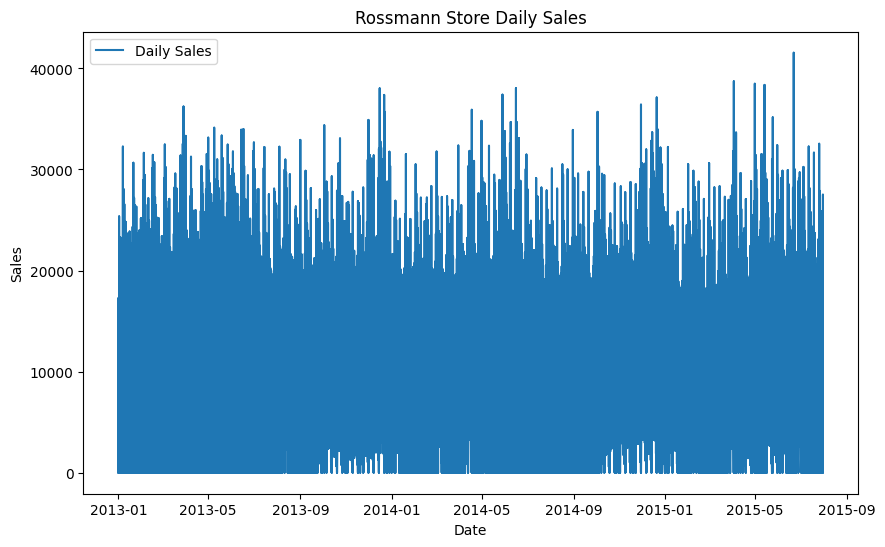

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data['Sales'], label='Daily Sales')
plt.title('Rossmann Store Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Check for stationarity using Augmented Dickey-Fuller Test


In [ ]:
result = adfuller(data['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [ ]:
# If data is not stationary, apply differencing
if result[1] > 0.05:
    print('Data is not stationary, applying differencing...')
    data_diff = data.diff().dropna()  # Differencing
else:
    print('Data is stationary.')
    data_diff = data.copy()

# Plot ACF and PACF


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['Sales'], lags=30, ax=plt.gca())
plt.subplot(122)
plot_pacf(data['Sales'], lags=30, ax=plt.gca())
plt.show()


### Convert the time series data into supervised learning data using a sliding window


In [11]:
def create_supervised_data(series, time_step=1):
    X, y = [], []
    for i in range(len(series) - time_step):
        X.append(series[i:(i + time_step)])
        y.append(series[i + time_step])
    return np.array(X), np.array(y)

## Prepare the supervised learning data


In [12]:
time_step = 30
sales_values = data['Sales'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
sales_scaled = scaler.fit_transform(sales_values)

X, y = create_supervised_data(sales_scaled, time_step)

# Split data into training and testing sets


In [13]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data for LSTM (samples, time steps, features)


In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and compile the LSTM model


In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Regularization
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\habteyes.asfaw\10Accadamy\Rossmann-Sales-Prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the LSTM model


In [16]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/5
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 827s 32ms/step - loss: 0.0192 - val_loss: 0.0154
Epoch 2/5
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 826s 32ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 3/5
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 727s 29ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 4/5
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 7720s 304ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 5/5
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 1213s 48ms/step - loss: 0.0121 - val_loss: 0.0102


# Make predictions


In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

25430/25430 ━━━━━━━━━━━━━━━━━━━━ 330s 13ms/step
6358/6358 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step


# Inverse scaling of the predictions


In [18]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actuals for test data


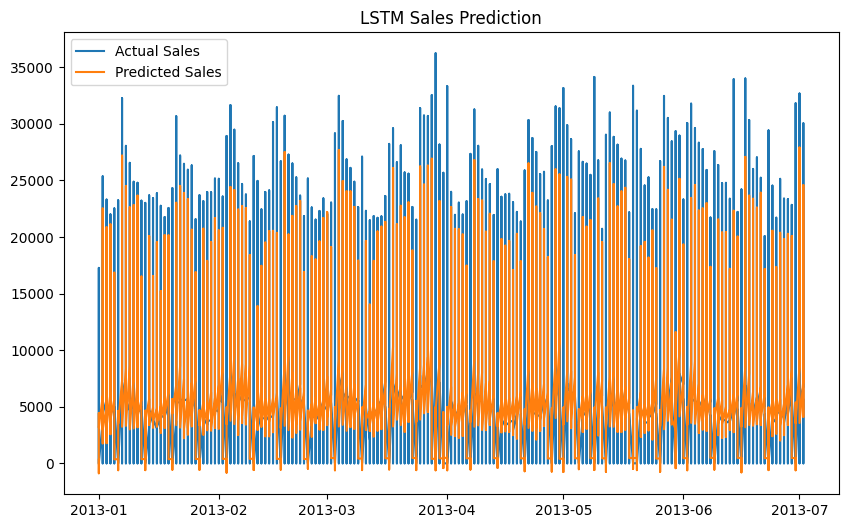

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test_inv, label='Actual Sales')
plt.plot(data.index[-len(y_test):], test_predict, label='Predicted Sales')
plt.title('LSTM Sales Prediction')
plt.legend()
plt.show()

# Calculate RMSE


In [20]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 2124.8122795768672
Test RMSE: 2098.8516924458436
